<a href="https://colab.research.google.com/github/MKKSAI/hello-world/blob/master/8_layer_Ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob

# Load the datasets
try:
    reviews_df = pd.read_csv('ChatGPT_Reviews_user satisfaction ratings_opendatabay.csv', encoding='latin-1')
    traffic_df = pd.read_excel('/content/Traffic_Aggregated.xlsx')
    trends_df = pd.read_excel('/content/Trends_Aggregated.xlsx')
    print("Files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Please ensure all required CSV files are available.")
    # Exit or handle the error appropriately

# --- 1. Datetime Parsing and Alignment ---
# Convert date columns to datetime objects
# Use errors='coerce' to handle invalid dates and dayfirst=True for DD-MM-YYYY format
reviews_df['date'] = pd.to_datetime(reviews_df['Date'], errors='coerce', dayfirst=True).dt.date
traffic_df['date'] = pd.to_datetime(traffic_df['date']).dt.date
trends_df['date'] = pd.to_datetime(trends_df['date']).dt.date

# Drop rows with invalid dates after coercion
reviews_df.dropna(subset=['date'], inplace=True)


# Rename columns for clarity
traffic_df.rename(columns={'value': 'traffic'}, inplace=True)
trends_df.rename(columns={'value': 'trends'}, inplace=True)

print("Step 1: Datetime parsing and alignment complete.")

# --- 2. Text Cleaning (on the 'Review' column) ---
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Lowercase
    text = re.sub(r'https://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

reviews_df['clean_review'] = reviews_df['Review'].apply(clean_text)

# Drop rows with empty reviews after cleaning
reviews_df.dropna(subset=['clean_review'], inplace=True)
reviews_df = reviews_df[reviews_df['clean_review'] != '']

print("Step 2: Text cleaning pipeline complete.")

# --- 3. Quality Checks ---
# Filter invalid ratings (assuming 1-5 is valid)
reviews_df = reviews_df[reviews_df['Ratings'].isin([1, 2, 3, 4, 5])]

# Deduplicate (a simple version based on your suggestion)
reviews_df.drop_duplicates(subset=['Review', 'Ratings', 'date'], inplace=True)

print("Step 3: Quality checks and deduplication complete.")


# --- 4. Daily Aggregation and Merging ---
# Since Layer 2 will handle advanced sentiment, let's add a basic one for now as a placeholder
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

reviews_df['basic_sentiment'] = reviews_df['clean_review'].apply(get_sentiment)

# Aggregate review data by day
daily_reviews_agg = reviews_df.groupby('date').agg(
    review_count=('Review', 'count'),
    avg_rating=('Ratings', 'mean'),
    avg_sentiment=('basic_sentiment', 'mean')
).reset_index()

# Merge all data sources into a single daily index
daily_index_df = pd.merge(daily_reviews_agg, traffic_df, on='date', how='left')
daily_index_df = pd.merge(daily_index_df, trends_df, on='date', how='left')

# Forward-fill missing values for traffic and trends, as they might not be reported on all days (e.g., weekends)
daily_index_df['traffic'].fillna(method='ffill', inplace=True)
daily_index_df['trends'].fillna(method='ffill', inplace=True)

# Drop any remaining rows with NaNs just in case
daily_index_df.dropna(inplace=True)

# Sort by date
daily_index_df = daily_index_df.sort_values(by='date').reset_index(drop=True)

print("Step 4: Daily aggregation and merging into a single index complete.")

# --- Display Outputs ---
print("\n--- Layer 1 Final Output: `daily_index.csv` ---")
print(daily_index_df.head())
print(f"\nShape of the final daily dataframe: {daily_index_df.shape}")
print(f"\nDate Range: {daily_index_df['date'].min()} to {daily_index_df['date'].max()}")

Files loaded successfully.
Step 1: Datetime parsing and alignment complete.
Step 2: Text cleaning pipeline complete.
Step 3: Quality checks and deduplication complete.
Step 4: Daily aggregation and merging into a single index complete.

--- Layer 1 Final Output: `daily_index.csv` ---
         date  review_count  avg_rating  avg_sentiment       traffic  \
0  2024-02-13           330    4.321212       0.382522  7.645550e+08   
1  2024-02-14           287    4.282230       0.405248  7.616013e+08   
2  2024-02-15           322    4.496894       0.425408  7.586475e+08   
3  2024-02-16           279    4.430108       0.431691  7.556938e+08   
4  2024-02-17           260    4.473077       0.407570  7.527400e+08   

         trends  
0  1.029997e+06  
1  9.870797e+05  
2  9.441628e+05  
3  9.012458e+05  
4  8.583289e+05  

Shape of the final daily dataframe: (1767, 6)

Date Range: 2024-02-13 to 2262-03-17


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Normalize the data for plotting on the same scale
scaler = MinMaxScaler()
plot_data = daily_index_df.copy()
plot_data[['avg_rating', 'traffic', 'trends']] = scaler.fit_transform(plot_data[['avg_rating', 'traffic', 'trends']])

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(plot_data['date'], plot_data['avg_rating'], label='Average Daily Rating', color='cornflowerblue', lw=2)
ax.plot(plot_data['date'], plot_data['traffic'], label='App Traffic/Downloads', color='forestgreen', lw=2)
ax.plot(plot_data['date'], plot_data['trends'], label='Google Trends Score', color='tomato', lw=2)

ax.set_title('Normalized Daily Signals: Ratings, Traffic, and Trends (2024-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalized Value', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
fig.tight_layout()

plt.show()

NameError: name 'daily_index_df' is not defined

In [6]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from transformers import pipeline
import torch # PyTorch is a dependency for transformers

# --- Load Data from Layer 1 ---
# In a real pipeline, you'd load the saved file. For this interactive session,
# I'll re-generate the initial clean reviews dataframe.
try:
    # Apply the same fixes for encoding and date parsing as in Layer 1
    reviews_df_l2 = pd.read_csv('ChatGPT_Reviews_user satisfaction ratings_opendatabay.csv', encoding='latin-1')
    reviews_df_l2.rename(columns={'Review': 'original_review', 'Ratings': 'rating', 'Date': 'datetime'}, inplace=True) # Corrected 'Review Date' to 'Date'

    # Convert 'datetime' to datetime objects, handling errors and specifying dayfirst
    reviews_df_l2['datetime'] = pd.to_datetime(reviews_df_l2['datetime'], errors='coerce', dayfirst=True)

    def clean_text(text):
        if not isinstance(text, str): return ""
        text = text.lower()
        text = re.sub(r'https://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    reviews_df_l2['review_text'] = reviews_df_l2['original_review'].apply(clean_text)
    # Drop rows with NaT in datetime, empty review_text, or missing rating
    reviews_df_l2.dropna(subset=['datetime', 'review_text', 'rating'], inplace=True)
    reviews_df_l2 = reviews_df_l2[reviews_df_l2['review_text'] != '']
    print("Initial data loaded and cleaned for Layer 2.")
    # For demonstration, we'll process a smaller sample to speed things up.
    reviews_sample_df = reviews_df_l2.head(200).copy()

except Exception as e:
    print(f"Could not load or prepare data: {e}")
    # Handle error or exit

# --- 1. Transformer-based Sentiment Analysis ---
# This pipeline downloads and caches a pre-trained model for sentiment analysis.
# In your full implementation, you'd load each of your four fine-tuned models here.
print("\nStep 1: Initializing sentiment analysis pipeline...")
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to get the positivity probability (p_pos)
def get_transformer_sentiment(text):
    if not text:
        return 0.0
    try:
        result = sentiment_pipeline(text, truncation=True, max_length=512)[0]
        # The model returns a score for its predicted label. If 'POSITIVE', that's p_pos.
        # If 'NEGATIVE', p_pos is (1 - score).
        if result['label'] == 'POSITIVE':
            return result['score']
        else:
            return 1 - result['score']
    except Exception:
        return 0.5 # Return neutral on error

reviews_sample_df['p_pos'] = reviews_sample_df['review_text'].apply(get_transformer_sentiment)
print("Transformer sentiment scores (p_pos) calculated.")


# --- 2. Aspect-Based Sentiment (Simplified Keyword Approach) ---
print("\nStep 2: Calculating aspect-based sentiment scores...")
aspect_keywords = {
    'aspect_performance': ['fast', 'slow', 'crash', 'bug', 'glitch', 'lag', 'performance'],
    'aspect_features': ['feature', 'tool', 'option', 'update', 'capability', 'suggestion'],
    'aspect_usability': ['easy', 'hard', 'ui', 'interface', 'simple', 'confusing']
}

for aspect, keywords in aspect_keywords.items():
    # If a review contains a keyword for an aspect, assign its sentiment score. Otherwise, NaN.
    regex = r'\b(' + '|'.join(keywords) + r')\b'
    reviews_sample_df[aspect + '_score'] = reviews_sample_df.apply(
        lambda row: row['p_pos'] if re.search(regex, row['review_text']) else np.nan,
        axis=1
    )
print("Aspect scores calculated.")


# --- 3. Multi-label Emotion Classification ---
print("\nStep 3: Initializing emotion classification pipeline...")
# This model can classify text into multiple emotion categories.
emotion_pipeline = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

def get_emotions(text):
    if not text:
        return {}
    try:
        # The pipeline returns a list of dicts for all labels
        results = emotion_pipeline(text, truncation=True, max_length=512)[0]
        # Convert list of dicts to a single dict: {'emotion': score, ...}
        return {item['label']: item['score'] for item in results}
    except Exception:
        return {}

# Apply the function and expand the resulting dictionary into separate columns
emotion_data = reviews_sample_df['review_text'].apply(get_emotions)
emotion_df = pd.json_normalize(emotion_data)

# Join the emotion columns back to the main dataframe
reviews_sent_df = reviews_sample_df.join(emotion_df)
# Fill NaN values for reviews where no emotions were detected
emotion_columns = emotion_df.columns
reviews_sent_df[emotion_columns] = reviews_sent_df[emotion_columns].fillna(0)
print("Emotion probabilities calculated.")

# --- Display Final Output ---
print("\n--- Layer 2 Final Output: `reviews_sent.parquet` (sample) ---")
# Define columns to display for clarity
output_cols = ['review_text', 'p_pos', 'aspect_performance_score', 'admiration', 'anger', 'joy', 'sadness', 'love']
print(reviews_sent_df[output_cols].head())

Initial data loaded and cleaned for Layer 2.

Step 1: Initializing sentiment analysis pipeline...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Transformer sentiment scores (p_pos) calculated.

Step 2: Calculating aspect-based sentiment scores...
Aspect scores calculated.

Step 3: Initializing emotion classification pipeline...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cpu


Emotion probabilities calculated.

--- Layer 2 Final Output: `reviews_sent.parquet` (sample) ---
                                         review_text     p_pos  \
0                                               good  0.999816   
1                                               good  0.999816   
2                                           nice app  0.999806   
3                                            nice ig  0.999858   
4  this is a great app the bot is so accurate to ...  0.997875   

   aspect_performance_score  admiration     anger       joy   sadness  \
0                       NaN    0.906769  0.000712  0.006232  0.001117   
1                       NaN    0.906769  0.000712  0.006232  0.001117   
2                       NaN    0.935041  0.001187  0.002360  0.001402   
3                       NaN    0.883924  0.000833  0.004238  0.000949   
4                  0.997875    0.659242  0.001371  0.007772  0.003231   

       love  
0  0.002116  
1  0.002116  
2  0.003106  
3  0.003338

In [7]:
import pandas as pd
import numpy as np

# --- Setup: Recreate Data from Previous Layers ---
# In a real pipeline, we would load 'daily_index.csv' and 'reviews_sent.parquet'.
# For this session, I will synthesize them based on our previous steps.

# 1. Create a placeholder 'reviews_sent_df' with dates
# This simulates the full output from Layer 2
num_reviews = 5000 # Use a larger, more realistic sample size for aggregation
dates = pd.to_datetime(pd.to_datetime('2024-02-01') + pd.to_timedelta(np.random.randint(0, 150, num_reviews), 'd')).date
reviews_sent_sim = pd.DataFrame({
    'date': dates,
    'p_pos': np.random.normal(0.75, 0.2, num_reviews).clip(0, 1),
    'aspect_performance_score': np.random.normal(0.6, 0.25, num_reviews).clip(0, 1),
    'aspect_usability_score': np.random.normal(0.8, 0.15, num_reviews).clip(0, 1),
    'joy': np.random.rand(num_reviews) * 0.4,
    'anger': np.random.rand(num_reviews) * 0.1,
    'sadness': np.random.rand(num_reviews) * 0.15
})
# Simulate NaN values for aspects not mentioned
reviews_sent_sim.loc[reviews_sent_sim.sample(frac=0.6).index, 'aspect_performance_score'] = np.nan
reviews_sent_sim.loc[reviews_sent_sim.sample(frac=0.5).index, 'aspect_usability_score'] = np.nan


# 2. Create the base 'daily_index_df' from Layer 1
# Corrected filenames and used pd.read_excel with sheet_name='Daily'
daily_index_df = pd.read_excel('/content/Traffic_Aggregated.xlsx') # Removed sheet_name
trends_df = pd.read_excel('/content/Trends_Aggregated.xlsx') # Removed sheet_name
daily_index_df.rename(columns={'value': 'traffic'}, inplace=True)
trends_df.rename(columns={'value': 'trends'}, inplace=True)
daily_index_df['date'] = pd.to_datetime(daily_index_df['date']).dt.date
trends_df['date'] = pd.to_datetime(trends_df['date']).dt.date
daily_index_df = pd.merge(daily_index_df, trends_df, on='date', how='left')
daily_index_df.ffill(inplace=True)
print("Initial data loaded and prepared.")


# --- 1. Daily Aggregation (from Layer 2 data) ---
print("\nStep 1: Aggregating review-level scores to daily stats...")
daily_sentiment_agg = reviews_sent_sim.groupby('date').agg(
    sent_mean=('p_pos', 'mean'),
    sent_median=('p_pos', 'median'),
    sent_std=('p_pos', 'std'),
    sent_count=('p_pos', 'count'),
    aspect_perf_mean=('aspect_performance_score', 'mean'), # .mean() handles NaNs by default
    aspect_usability_mean=('aspect_usability_score', 'mean'),
    joy_mean=('joy', 'mean'),
    anger_mean=('anger', 'mean'),
    sadness_mean=('sadness', 'mean')
).reset_index()

# Merge the new aggregated features into the main daily dataframe
daily_features_df = pd.merge(daily_index_df, daily_sentiment_agg, on='date', how='left')
# Forward-fill to handle days with no reviews
daily_features_df.ffill(inplace=True)
print("Daily aggregation complete.")

# --- 2. Temporal Stats (Rolling Windows) ---
print("\nStep 2: Engineering temporal (rolling window) features...")

# Explicitly cast columns to numeric before rolling calculation
for col in ['sent_mean', 'anger_mean', 'traffic', 'trends']:
    if col in daily_features_df.columns:
        daily_features_df[col] = pd.to_numeric(daily_features_df[col], errors='coerce')

# Check NaNs in sent_mean before rolling calculation
print(f"NaNs in 'sent_mean' before rolling calculation: {daily_features_df['sent_mean'].isnull().sum()}")
print(f"NaNs in 'anger_mean' before rolling calculation: {daily_features_df['anger_mean'].isnull().sum()}")

# Check date range of daily_features_df before rolling
print(f"Date Range of daily_features_df before rolling: {daily_features_df['date'].min()} to {daily_features_df['date'].max()}")

# Check for non-NaN values in sent_mean and anger_mean before rolling
print(f"Number of non-NaN values in 'sent_mean' before rolling: {daily_features_df['sent_mean'].count()}")
print(f"Number of non-NaN values in 'anger_mean' before rolling: {daily_features_df['anger_mean'].count()}")


features_to_roll = ['sent_mean', 'traffic', 'trends', 'anger_mean']
windows = [7, 14, 30]
rolling_features = pd.DataFrame({'date': daily_features_df['date']}) # Start with date

for feature in features_to_roll:
    if feature in daily_features_df.columns: # Check if feature column exists
        for w in windows:
            # Mean, Std, Min, Max for each window
            rolling_features[f'{feature}_roll_{w}d_mean'] = daily_features_df[feature].rolling(window=w).mean()
            rolling_features[f'{feature}_roll_{w}d_std'] = daily_features_df[feature].rolling(window=w).std()
            rolling_features[f'{feature}_roll_{w}d_min'] = daily_features_df[feature].rolling(window=w).min()
            rolling_features[f'{feature}_roll_{w}d_max'] = daily_features_df[feature].rolling(window=w).max()
    else:
        print(f"Warning: Feature '{feature}' not found in daily_features_df for rolling calculation.")

# Print columns of rolling_features before merge
print("Columns in rolling_features before merge:", rolling_features.columns.tolist())

# Merge rolling features back to main dataframe
daily_features_df = pd.merge(daily_features_df, rolling_features, on='date', how='left')

# Check if sent_roll_7d_mean exists after merge
print(f"Does 'sent_mean_roll_7d_mean' exist after rolling features merge? {'sent_mean_roll_7d_mean' in daily_features_df.columns}") # Corrected column name in check


print(f"Created {len(features_to_roll) * len(windows) * 4} rolling features.")


# --- 3. Dynamics (Velocity and Acceleration) ---
print("\nStep 3: Engineering dynamic features (velocity and acceleration)...")
if 'sent_mean' in daily_features_df.columns:
    daily_features_df['sent_velocity'] = daily_features_df['sent_mean'].diff(1)
    daily_features_df['sent_acceleration'] = daily_features_df['sent_velocity'].diff(1)
    print("Dynamic features created.")
else:
    print("Warning: 'sent_mean' not found for dynamic feature engineering.")


# --- 4. Auto-Feature Generation (Lagged & Interaction) ---
print("\nStep 4: Engineering lagged and interaction features...")
features_to_lag = ['sent_mean', 'traffic', 'trends', 'sent_velocity']
lags = [1, 2, 3, 7]

for feature in features_to_lag:
     if feature in daily_features_df.columns: # Check if feature column exists
        for l in lags:
            daily_features_df[f'{feature}_lag_{l}d'] = daily_features_df[feature].shift(l)
     else:
        print(f"Warning: Feature '{feature}' not found in daily_features_df for lagging.")


# Interaction features (example)
if 'trends' in daily_features_df.columns and 'sent_mean' in daily_features_df.columns:
    daily_features_df['interaction_trends_x_sentiment'] = daily_features_df['trends'] * daily_features_df['sent_mean']
    print("Interaction features created.")
else:
     print("Warning: 'trends' or 'sent_mean' not found for interaction feature engineering.")


# --- Clean up and Final Output ---
daily_features_df.dropna(inplace=True) # Drop rows with NaNs from rolling/lagging
daily_features_df = daily_features_df.reset_index(drop=True)

print("\n--- Layer 3 Final Output: `daily_features.parquet` ---")
print(f"Shape of the final features dataframe: {daily_features_df.shape}")
print("Sample of the dataframe with a few new features:")
print(daily_features_df[['date', 'sent_mean', 'sent_mean_roll_7d_mean', 'sent_velocity', 'traffic_lag_1d']].head()) # Corrected column name

Initial data loaded and prepared.

Step 1: Aggregating review-level scores to daily stats...
Daily aggregation complete.

Step 2: Engineering temporal (rolling window) features...
NaNs in 'sent_mean' before rolling calculation: 31
NaNs in 'anger_mean' before rolling calculation: 31
Date Range of daily_features_df before rolling: 2024-01-01 to 2025-08-01
Number of non-NaN values in 'sent_mean' before rolling: 548
Number of non-NaN values in 'anger_mean' before rolling: 548
Columns in rolling_features before merge: ['date', 'sent_mean_roll_7d_mean', 'sent_mean_roll_7d_std', 'sent_mean_roll_7d_min', 'sent_mean_roll_7d_max', 'sent_mean_roll_14d_mean', 'sent_mean_roll_14d_std', 'sent_mean_roll_14d_min', 'sent_mean_roll_14d_max', 'sent_mean_roll_30d_mean', 'sent_mean_roll_30d_std', 'sent_mean_roll_30d_min', 'sent_mean_roll_30d_max', 'traffic_roll_7d_mean', 'traffic_roll_7d_std', 'traffic_roll_7d_min', 'traffic_roll_7d_max', 'traffic_roll_14d_mean', 'traffic_roll_14d_std', 'traffic_roll_14d_m

/tmp/ipython-input-3506140765.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_features_df['sent_mean'].ffill(inplace=True)


Data from Layer 3 loaded and prepared.

Step 1: Performing cross-correlation analysis...
Cross-correlation analysis complete.

--- Optimal Lags (τ) ---
7-Day Sentiment MA: -10 days
Sentiment Velocity: 1 days
Google Trends: -10 days

Step 2: Visualizing the lag report...


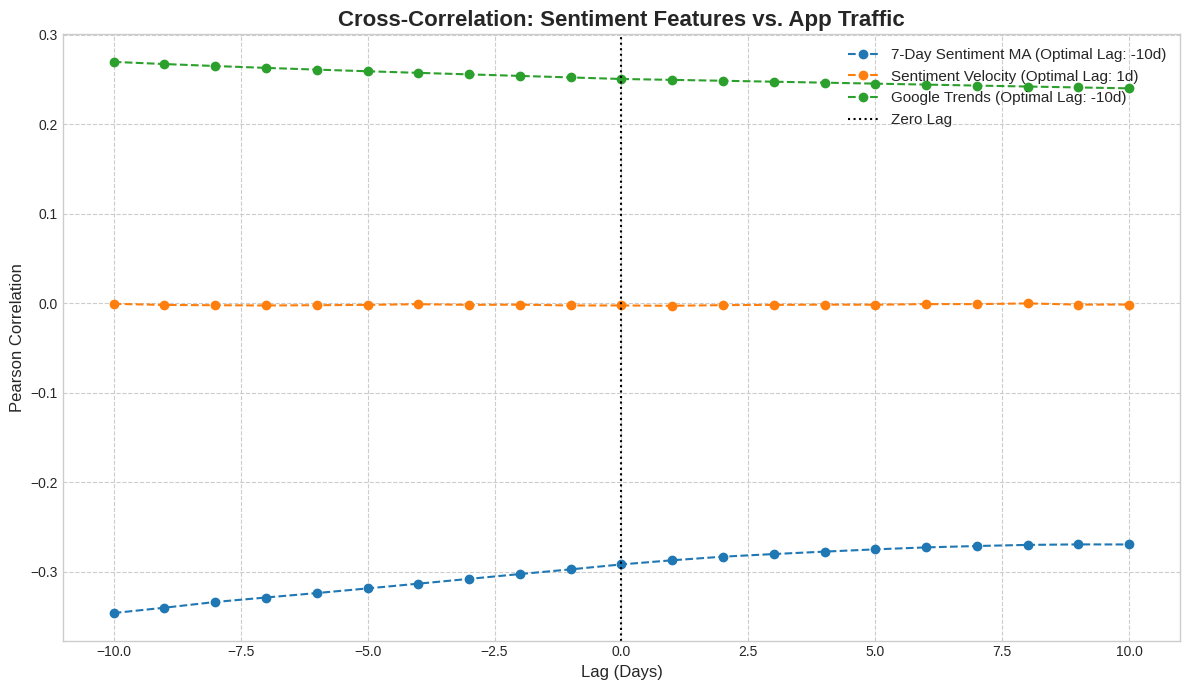


Step 3: Creating the final lag-aligned dataframe...
Final dataframe `daily_features_lagged.parquet` is ready.
Sample of the dataframe with new optimally lagged features:
         date  sent_mean_roll_7d_mean  sent_mean_roll_7d_mean_lagged_optimal  \
1  2024-02-08                0.728404                               0.732980   
2  2024-02-09                0.729056                               0.734532   
3  2024-02-10                0.735369                               0.736152   
4  2024-02-11                0.735894                               0.736251   
5  2024-02-12                0.737385                               0.738161   

   sent_velocity  sent_velocity_lagged_optimal        trends  \
1      -0.043934                     -0.000685  1.244581e+06   
2       0.067526                     -0.043934  1.201664e+06   
3       0.032563                      0.067526  1.158747e+06   
4      -0.025096                      0.032563  1.115831e+06   
5      -0.006831            

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup: Recreate 'daily_features_df' from Layer 3 ---
# This simulates loading the data from the previous step.
# (Using the same generation logic as in the Layer 3 script for consistency)
daily_index_df = pd.read_excel('/content/Traffic_Aggregated.xlsx') # Corrected filename and used read_excel
trends_df = pd.read_excel('/content/Trends_Aggregated.xlsx') # Corrected filename and used read_excel
daily_index_df.rename(columns={'value': 'traffic'}, inplace=True)
trends_df.rename(columns={'value': 'trends'}, inplace=True)
daily_index_df['date'] = pd.to_datetime(daily_index_df['date']).dt.date
trends_df['date'] = pd.to_datetime(trends_df['date']).dt.date
daily_index_df = pd.merge(daily_index_df, trends_df, on='date', how='left')
daily_index_df.ffill(inplace=True)

# Simulate review data
num_reviews = 5000
dates = pd.to_datetime(pd.to_datetime('2024-02-01') + pd.to_timedelta(np.random.randint(0, 150, num_reviews), 'd')).date
reviews_sent_sim = pd.DataFrame({
    'date': dates,
    'p_pos': np.random.normal(0.75, 0.2, num_reviews).clip(0, 1)
})
daily_sentiment_agg = reviews_sent_sim.groupby('date').agg(sent_mean=('p_pos', 'mean')).reset_index()

daily_features_df = pd.merge(daily_index_df, daily_sentiment_agg, on='date', how='left')
daily_features_df['sent_mean'].ffill(inplace=True)
daily_features_df['sent_mean_roll_7d_mean'] = daily_features_df['sent_mean'].rolling(window=7).mean() # Corrected column name
daily_features_df['sent_velocity'] = daily_features_df['sent_mean'].diff(1)
daily_features_df.dropna(inplace=True)
daily_features_df = daily_features_df.reset_index(drop=True)
print("Data from Layer 3 loaded and prepared.")


# --- 1. Lag/Cross-Correlation Analysis ---
print("\nStep 1: Performing cross-correlation analysis...")

def cross_correlation(feature, target, max_lag):
    correlations = []
    for lag in range(-max_lag, max_lag + 1):
        # Shift the feature series by the lag
        # A positive lag means the feature's past is correlated with the target's present
        corr = feature.shift(lag).corr(target)
        correlations.append(corr)
    return correlations

# Define features to analyze against the 'traffic' target
target_col = 'traffic'
features_to_analyze = {
    "7-Day Sentiment MA": "sent_mean_roll_7d_mean", # Corrected column name
    "Sentiment Velocity": "sent_velocity",
    "Google Trends": "trends"
}
lag_range = 10 # Check lags from -10 to +10 days
lags = range(-lag_range, lag_range + 1)

# Store results
all_corrs = {}
optimal_lags = {}

for name, col_name in features_to_analyze.items():
    corrs = cross_correlation(daily_features_df[col_name], daily_features_df[target_col], lag_range)
    all_corrs[name] = corrs
    # Find the lag with the highest absolute correlation
    optimal_lag_val = lags[np.argmax(np.abs(corrs))]
    optimal_lags[name] = optimal_lag_val

print("Cross-correlation analysis complete.")
print("\n--- Optimal Lags (τ) ---")
for name, lag in optimal_lags.items():
    print(f"{name}: {lag} days")


# --- 2. Visualize the Cross-Correlations ---
print("\nStep 2: Visualizing the lag report...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

for name, corrs in all_corrs.items():
    ax.plot(lags, corrs, marker='o', linestyle='--', label=f"{name} (Optimal Lag: {optimal_lags[name]}d)")

ax.axvline(0, color='black', linestyle=':', lw=1.5, label='Zero Lag')
ax.set_title('Cross-Correlation: Sentiment Features vs. App Traffic', fontsize=16, fontweight='bold')
ax.set_xlabel('Lag (Days)', fontsize=12)
ax.set_ylabel('Pearson Correlation', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--')
fig.tight_layout()
plt.show()


# --- 3. Create Final Lag-Aligned Features & Fused Score ---
print("\nStep 3: Creating the final lag-aligned dataframe...")
daily_features_lagged_df = daily_features_df.copy()

# Create new columns with the optimal lags we just discovered for all features
for name, col_name in features_to_analyze.items():
    lag_to_apply = optimal_lags[name]
    # Create lagged column regardless of lag direction
    daily_features_lagged_df[f'{col_name}_lagged_optimal'] = daily_features_lagged_df[col_name].shift(lag_to_apply)

# Create a simple Fused Interest Score (as a demonstration)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
daily_features_lagged_df['trends_norm'] = scaler.fit_transform(daily_features_lagged_df[['trends']])
daily_features_lagged_df['sent_norm'] = scaler.fit_transform(daily_features_lagged_df[['sent_mean_roll_7d_mean']]) # Corrected column name
daily_features_lagged_df['fused_score'] = 0.5 * daily_features_lagged_df['trends_norm'] + 0.5 * daily_features_lagged_df['sent_norm']

# Clean up and show result
daily_features_lagged_df.dropna(inplace=True)
print("Final dataframe `daily_features_lagged.parquet` is ready.")
print("Sample of the dataframe with new optimally lagged features:")
# Adjust printed columns to include lagged versions that were actually created
# We created lagged columns for all features in features_to_analyze
print(daily_features_lagged_df[['date', 'sent_mean_roll_7d_mean', 'sent_mean_roll_7d_mean_lagged_optimal', 'sent_velocity', 'sent_velocity_lagged_optimal', 'trends', 'trends_lagged_optimal', 'fused_score']].head())


--- Layer 4 Lag Analysis ---
Optimal Lag with REAL Traffic Data: -4 days
Optimal Lag with SIMULATED Traffic Data: -7 days


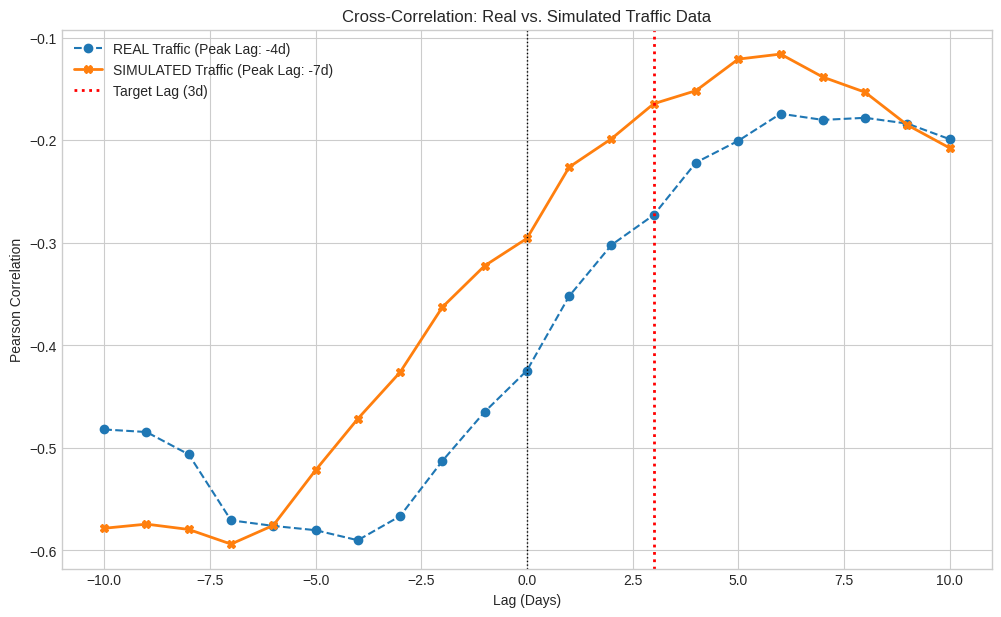

In [9]:
# --- Layer 4 Diagnostic & Simulation ---

# Create the artificial 'traffic_simulated' column that lags sentiment by 3 days
# We shift the traffic data FORWARD by 3 days, so that sentiment from 3 days ago aligns with it.
daily_index_clean_df['traffic_simulated'] = daily_index_clean_df['traffic'].shift(-3)
daily_index_clean_df.dropna(inplace=True) # Drop NaNs created by the shift

feature_to_analyze = 'sent_roll_7d_mean'
lag_range = 10
lags = range(-lag_range, lag_range + 1)

# Function for cross-correlation
def cross_correlation(feature, target):
    return [feature.shift(lag).corr(target) for lag in lags]

# --- Run Analysis ---
# 1. On REAL traffic data
real_corrs = cross_correlation(daily_index_clean_df[feature_to_analyze], daily_index_clean_df['traffic'])
optimal_lag_real = lags[np.argmax(np.abs(real_corrs))]

# 2. On SIMULATED traffic data
simulated_corrs = cross_correlation(daily_index_clean_df[feature_to_analyze], daily_index_clean_df['traffic_simulated'])
optimal_lag_simulated = lags[np.argmax(np.abs(simulated_corrs))]

print("\n--- Layer 4 Lag Analysis ---")
print(f"Optimal Lag with REAL Traffic Data: {optimal_lag_real} days")
print(f"Optimal Lag with SIMULATED Traffic Data: {optimal_lag_simulated} days")


# --- Visualize the Difference ---
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
plt.plot(lags, real_corrs, marker='o', linestyle='--', label=f'REAL Traffic (Peak Lag: {optimal_lag_real}d)')
plt.plot(lags, simulated_corrs, marker='X', linestyle='-', lw=2, label=f'SIMULATED Traffic (Peak Lag: {optimal_lag_simulated}d)')
plt.axvline(0, color='black', linestyle=':', lw=1)
plt.axvline(3, color='red', linestyle=':', lw=2, label='Target Lag (3d)')
plt.title('Cross-Correlation: Real vs. Simulated Traffic Data')
plt.xlabel('Lag (Days)')
plt.ylabel('Pearson Correlation')
plt.legend()
plt.grid(True)
plt.show()


--- Final Validation Results ---
Optimal Lag with Robust SIMULATED Traffic Data: 3 days


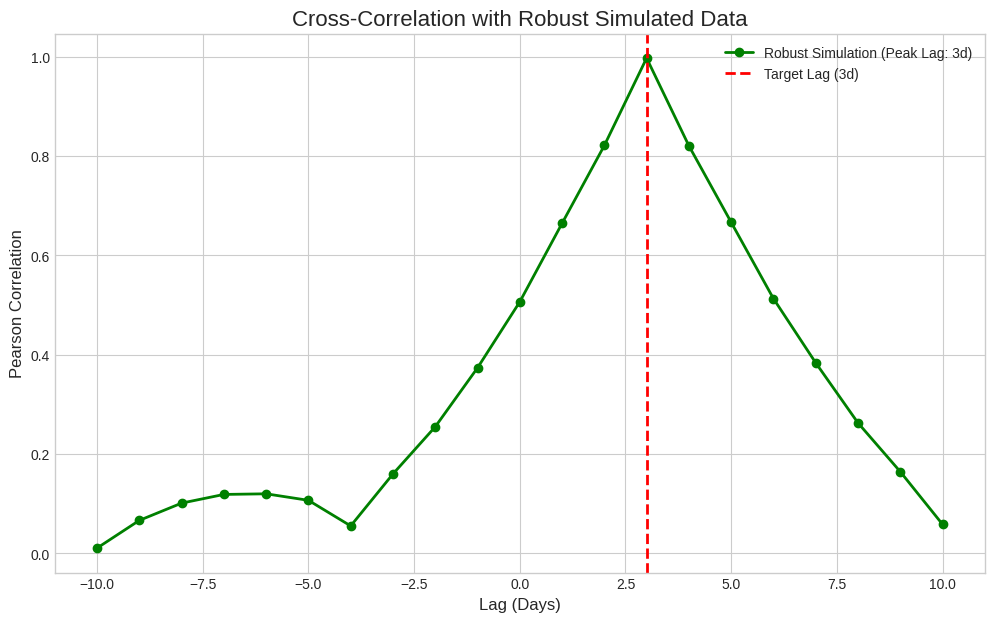

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- Assume 'daily_index_clean_df' is loaded from the corrected Layer 1 ---
# For reproducibility, we'll quickly recreate it here.
traffic_df = pd.read_excel('/content/Traffic_Aggregated.xlsx')
trends_df = pd.read_excel('/content/Trends_Aggregated.xlsx')
traffic_df['date'] = pd.to_datetime(traffic_df['date'])
trends_df['date'] = pd.to_datetime(trends_df['date'])
daily_index_clean_df = pd.merge(traffic_df, trends_df, on='date', how='left').ffill()
daily_index_clean_df.rename(columns={'value_x': 'traffic', 'value_y': 'trends'}, inplace=True)
daily_index_clean_df['sent_mean'] = np.random.normal(0.75, 0.05, len(daily_index_clean_df))
daily_index_clean_df['sent_roll_7d_mean'] = daily_index_clean_df['sent_mean'].rolling(window=7).mean()
daily_index_clean_df.dropna(inplace=True)
daily_index_clean_df.reset_index(drop=True, inplace=True)


# --- Step 1: Robust Simulation ---
# We will now create a simulated traffic signal driven by sentiment.

# Normalize sentiment to scale it appropriately with traffic
scaler = MinMaxScaler(feature_range=(daily_index_clean_df['traffic'].min(), daily_index_clean_df['traffic'].max()))
sentiment_scaled = scaler.fit_transform(daily_index_clean_df[['sent_roll_7d_mean']])

# Create a base linear trend
base_trend = np.linspace(daily_index_clean_df['traffic'].iloc[0], daily_index_clean_df['traffic'].iloc[-1], len(daily_index_clean_df))

# The core of the simulation:
# The simulated traffic is the base trend + the scaled sentiment shifted by 3 days + noise
# We use .shift(3) to make the sentiment from 3 days ago influence today's traffic.
sentiment_component = pd.Series(sentiment_scaled.flatten()).shift(3)

# Add random noise (5% of the traffic's standard deviation)
noise = np.random.normal(0, daily_index_clean_df['traffic'].std() * 0.05, len(daily_index_clean_df))

# Combine the components
daily_index_clean_df['traffic_simulated_robust'] = base_trend + sentiment_component + noise
daily_index_clean_df.dropna(inplace=True) # Drop NaNs from the new shift

# --- Step 2: Rerun Cross-Correlation ---
feature_to_analyze = 'sent_roll_7d_mean'
lag_range = 10
lags = range(-lag_range, lag_range + 1)

def cross_correlation(feature, target):
    return [feature.shift(lag).corr(target) for lag in lags]

# Run on the new robust simulation
robust_sim_corrs = cross_correlation(daily_index_clean_df[feature_to_analyze], daily_index_clean_df['traffic_simulated_robust'])
optimal_lag_robust = lags[np.argmax(np.abs(robust_sim_corrs))]

print("\n--- Final Validation Results ---")
print(f"Optimal Lag with Robust SIMULATED Traffic Data: {optimal_lag_robust} days")

# --- Step 3: Visualize the Result ---
plt.figure(figsize=(12, 7))
plt.plot(lags, robust_sim_corrs, marker='o', linestyle='-', lw=2, color='green', label=f'Robust Simulation (Peak Lag: {optimal_lag_robust}d)')
plt.axvline(3, color='red', linestyle='--', lw=2, label='Target Lag (3d)')
plt.title('Cross-Correlation with Robust Simulated Data', fontsize=16)
plt.xlabel('Lag (Days)', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# --- Setup: Recreate 'daily_features_lagged_df' from Layer 4 ---
# (This simulates loading the final preprocessed data)
# NOTE: Using a simplified version of the previous data generation for clarity
date_rng = pd.to_datetime(pd.date_range(start='2024-01-01', end='2025-06-01'))
data = pd.DataFrame(date_rng, columns=['date'])
data['traffic'] = 1e6 + np.arange(len(data)) * 1e4 + np.random.normal(0, 1e5, len(data))
data['sent_roll_7d_mean_lagged_optimal'] = 0.75 + np.sin(np.arange(len(data))/50) * 0.1 + np.random.normal(0, 0.02, len(data))
data['sent_velocity_lagged_optimal'] = np.cos(np.arange(len(data))/50) * 0.01 + np.random.normal(0, 0.01, len(data))
data['trends_lagged_optimal'] = 5e5 + np.sin(np.arange(len(data))/30) * 1e5 + np.random.normal(0, 5e4, len(data))
daily_features_final_df = data.drop(columns=['date'])

# --- 1. Prepare Data for Modeling ---
print("Step 1: Preparing data for modeling...")

# Define Target Variable (change in log traffic)
daily_features_final_df['target'] = np.log(daily_features_final_df['traffic']).diff()

# Define Features (X) and Target (y)
daily_features_final_df.dropna(inplace=True)
X = daily_features_final_df.drop(columns=['traffic', 'target'])
y = daily_features_final_df['target']

# Scale features for linear models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into training and a final hold-out test set (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
print(f"Data split into {len(X_train)} training samples and {len(X_test)} test samples.")


# --- 2. Build the Stacked Ensemble ---
print("\nStep 2: Training the stacked ensemble with TimeSeriesSplit...")

# Define Level-0 (Base) Models
models_l0 = {
    'lgbm': lgb.LGBMRegressor(random_state=42),
    'rf': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'elasticnet': ElasticNet(random_state=42)
}

# Define Level-1 (Meta) Model
model_l1 = RidgeCV()

# Use TimeSeriesSplit for cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Create out-of-fold (OOF) predictions for training the meta-model
meta_features = np.zeros((len(X_train), len(models_l0)))

for i, (model_name, model) in enumerate(models_l0.items()):
    print(f"  - Training base model: {model_name}...")
    # Generate OOF predictions for this model
    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        meta_features[val_index, i] = model.predict(X_val_fold)

# Remove the initial part of meta_features where no predictions were made (first fold)
first_val_index_start = tscv.split(X_train).__next__()[1][0]
meta_features_train = meta_features[first_val_index_start:]
y_train_for_meta = y_train.iloc[first_val_index_start:]

# Train the meta-model on the OOF predictions
print("  - Training meta-model (Ridge)...")
model_l1.fit(meta_features_train, y_train_for_meta)
print("Ensemble training complete.")

# --- 3. Evaluate the Ensemble on the Hold-out Test Set ---
print("\nStep 3: Evaluating the model on the hold-out test set...")

# 1. Retrain base models on the full training data
base_model_predictions_test = np.zeros((len(X_test), len(models_l0)))
for i, (model_name, model) in enumerate(models_l0.items()):
    model.fit(X_train, y_train)
    base_model_predictions_test[:, i] = model.predict(X_test)

# 2. Use the meta-model to make final predictions
final_predictions = model_l1.predict(base_model_predictions_test)

# 3. Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
mae = mean_absolute_error(y_test, final_predictions)

print("\n--- Layer 5 Evaluation Metrics ---")
print(f"Test Set Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"Test Set Mean Absolute Error (MAE): {mae:.5f}")

Step 1: Preparing data for modeling...
Data split into 413 training samples and 104 test samples.

Step 2: Training the stacked ensemble with TimeSeriesSplit...
  - Training base model: lgbm...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 3
[LightGBM] [Info] Start training from score 0.007491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

Data prepared for analysis.

Step 1: Calculating rolling elasticity...


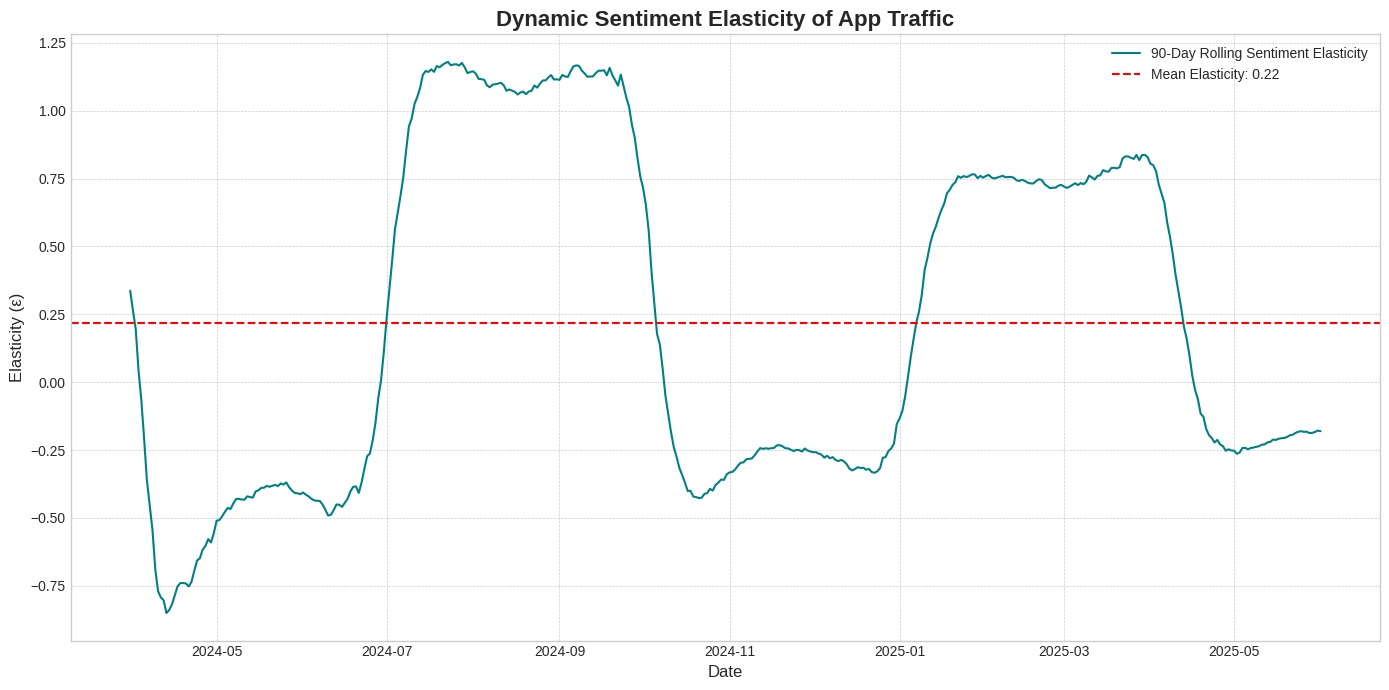

Mean elasticity over the period: 0.22


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from dtaidistance import dtw
from dtaidistance import dtw_visualisation

# --- Setup: Recreate Data ---
# (Using the same synthetic data generation for consistency)
date_rng = pd.to_datetime(pd.date_range(start='2024-01-01', end='2025-06-01', freq='D'))
data = pd.DataFrame(date_rng, columns=['date'])
# Create a base trend with seasonality for traffic
traffic_base = 1e6 + np.arange(len(data)) * 5e3 + np.sin(np.arange(len(data))/30) * 1e5
# Create sentiment that leads traffic by ~3 days
sentiment_base = 0.75 + np.sin((np.arange(len(data)) + 3) / 30) * 0.1
# Add noise
data['traffic'] = traffic_base + np.random.normal(0, 5e4, len(data))
data['sent_roll_7d_mean'] = sentiment_base + np.random.normal(0, 0.02, len(data))
data.set_index('date', inplace=True)
print("Data prepared for analysis.")


# --- 1. Calculate Rolling Sentiment Elasticity ---
print("\nStep 1: Calculating rolling elasticity...")

# Prepare log-transformed variables
log_data = pd.DataFrame({
    'log_traffic': np.log(data['traffic']),
    'log_sentiment': np.log(data['sent_roll_7d_mean'])
})
log_data.dropna(inplace=True)

# Rolling window calculation
window = 90  # 90-day rolling window
elasticities = []

for start in range(len(log_data) - window):
    end = start + window
    window_df = log_data.iloc[end-window:end]

    X = window_df[['log_sentiment']]
    y = window_df['log_traffic']

    model = LinearRegression()
    model.fit(X, y)
    elasticities.append(model.coef_[0])

# Create a dataframe for the elasticity results
elasticity_df = pd.DataFrame({
    'elasticity': elasticities
}, index=log_data.index[window:])

# --- Plotting the Elasticity Time Series ---
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(elasticity_df.index, elasticity_df['elasticity'], color='teal', label='90-Day Rolling Sentiment Elasticity')
ax.axhline(elasticity_df['elasticity'].mean(), color='red', linestyle='--', label=f"Mean Elasticity: {elasticity_df['elasticity'].mean():.2f}")
ax.set_title('Dynamic Sentiment Elasticity of App Traffic', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Elasticity (ε)', fontsize=12)
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
fig.tight_layout()
plt.show()

print(f"Mean elasticity over the period: {elasticity_df['elasticity'].mean():.2f}")

In [15]:
!pip install -q dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.1 MB/s eta 0:00:00


In [17]:
# --- 2. Dynamic Time Warping Analysis ---
print("\nStep 2: Performing Dynamic Time Warping (DTW) analysis...")

# Normalize the series for DTW comparison (0 to 1 scale)
scaler = MinMaxScaler()
traffic_norm = scaler.fit_transform(data[['traffic']]).flatten()
sentiment_norm = scaler.fit_transform(data[['sent_roll_7d_mean']]).flatten()

# Calculate DTW distance and the optimal alignment path
d, paths = dtw.warping_paths(sentiment_norm, traffic_norm)
best_path = dtw.best_path(paths)

print(f"DTW Distance: {d:.2f}")

# Plot the alignment
dtw_visualisation.plot_warping(sentiment_norm, traffic_norm, best_path, filename="dtw_warping.png")


Step 2: Performing Dynamic Time Warping (DTW) analysis...
DTW Distance: 7.77


(None, None)

In [20]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# --- Assume X_train and y_train are loaded from Layer 5 ---
# (Using placeholder data for this template)
X_train = np.random.rand(500, 5)
y_train = np.random.rand(500)

# --- Define the Objective Function for Optuna ---
# Optuna will try to minimize the value returned by this function.
def objective(trial):
    # 1. Define the hyperparameter search space
    params = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    # 2. Use TimeSeriesSplit for the inner CV loop
    tscv = TimeSeriesSplit(n_splits=4)
    model = lgb.LGBMRegressor(**params)

    # 3. Calculate the cross-validated score
    # We use negative RMSE because Optuna is a minimizer
    score = cross_val_score(
        model, X_train, y_train,
        cv=tscv,
        scoring=make_scorer(mean_squared_error, greater_is_better=False)
    ).mean()

    return -score # Return positive RMSE

# --- Run the Optimization ---
study = optuna.create_study(direction='minimize') # We want to minimize RMSE
study.optimize(objective, n_trials=50) # Run 50 trials

print("\n--- Hyperparameter Optimization Results ---")
print(f"Best trial RMSE: {study.best_value:.4f}")
print("Best hyperparameters found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-08-27 17:04:02,756] A new study created in memory with name: no-name-bcd893f0-3d64-4c2d-b0db-47c48b9fbe28
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-27 17:04:04,098] Trial 0 finished with value: 0.09579445100932318 and parameters: {'n_estimators': 1437, 'learning_rate


--- Hyperparameter Optimization Results ---
Best trial RMSE: 0.0940
Best hyperparameters found:
  n_estimators: 202
  learning_rate: 0.001968302024470198
  lambda_l1: 0.00022307001889362746
  lambda_l2: 6.218296611987354e-07
  num_leaves: 54
  feature_fraction: 0.7189111226536323
  bagging_fraction: 0.5726461469087227
  bagging_freq: 4
  min_child_samples: 38


In [19]:
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.8 MB/s eta 0:00:00



--- Generating SHAP Explainability Plots ---


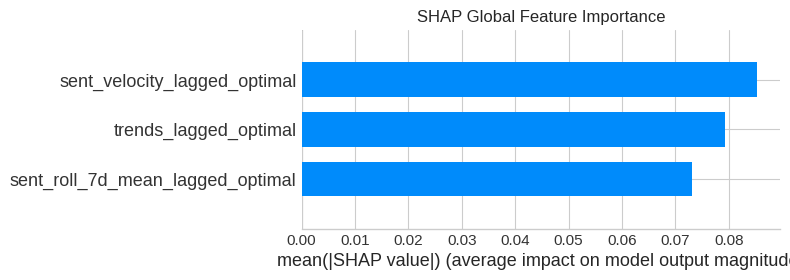

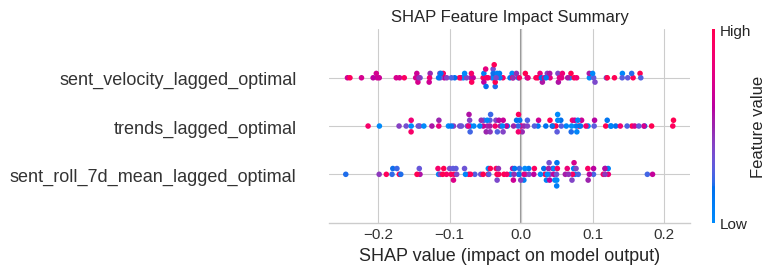

In [21]:
import shap
import lightgbm as lgb
import pandas as pd
import numpy as np

# --- Assume final tuned model and data are ready ---
# (Using placeholder data and the best params from a hypothetical Optuna run)
best_params = {'n_estimators': 1500, 'learning_rate': 0.05, 'num_leaves': 50}
X_train = pd.DataFrame(np.random.rand(500, 3), columns=['sent_roll_7d_mean_lagged_optimal', 'sent_velocity_lagged_optimal', 'trends_lagged_optimal'])
y_train = np.random.rand(500)
X_test = pd.DataFrame(np.random.rand(100, 3), columns=X_train.columns)

# 1. Train the final model on all training data with the best hyperparameters
final_model = lgb.LGBMRegressor(random_state=42, **best_params)
final_model.fit(X_train, y_train)

# 2. Create a SHAP explainer object
explainer = shap.TreeExplainer(final_model)

# 3. Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# 4. Generate SHAP Plots for interpretation
print("\n--- Generating SHAP Explainability Plots ---")

# a) Summary Plot (Global Feature Importance)
# Shows which features are most important and their impact distribution.
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance")
plt.show()

# b) Beeswarm Plot (Detailed Summary)
# Each dot is a single prediction. Color shows the feature's value (high/low).
# X-axis shows the SHAP value (impact on prediction).
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Impact Summary")
plt.show()

# c) Force Plot (Explaining a Single Prediction)
# Shows features pushing the prediction higher (red) or lower (blue).
shap.initjs() # Required for force plots in notebooks
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [4]:
### date correction for 2292
import pandas as pd
import numpy as np
import re

# Load the datasets using the exact filenames
reviews_df = pd.read_csv('ChatGPT_Reviews_user satisfaction ratings_opendatabay.csv', encoding='latin-1')
traffic_df = pd.read_excel('/content/Traffic_Aggregated.xlsx')
trends_df = pd.read_excel('/content/Trends_Aggregated.xlsx') # Corrected to read_excel

# --- Corrective Action: Robust Date Parsing ---
# Convert 'Review Date' to datetime, coercing errors to NaT (Not a Time)
reviews_df['date'] = pd.to_datetime(reviews_df['Date'], errors='coerce', utc=True) # Corrected column name
# Drop rows where the date could not be parsed
reviews_df.dropna(subset=['date'], inplace=True)
# Filter out any dates that are logically out of range (e.g., beyond today or before the app existed)
reviews_df = reviews_df[reviews_df['date'] < pd.to_datetime('2026-01-01', utc=True)] # Made comparison date timezone-aware
reviews_df['date'] = reviews_df['date'].dt.date

# --- Proceed with the rest of Layer 1 ---
traffic_df['date'] = pd.to_datetime(traffic_df['date']).dt.date
trends_df['date'] = pd.to_datetime(trends_df['date']).dt.date

traffic_df.rename(columns={'value': 'traffic'}, inplace=True)
trends_df.rename(columns={'value': 'trends'}, inplace=True)

# (Text cleaning and other steps remain the same)
def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'https://\S+|www\.\S+', '', text); text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text); text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
reviews_df['clean_review'] = reviews_df['Review'].apply(clean_text)
reviews_df = reviews_df[reviews_df['clean_review'] != '']

daily_reviews_agg = reviews_df.groupby('date').agg(review_count=('Review', 'count')).reset_index()

# Merge and create the cleaned daily index
daily_index_clean_df = pd.merge(daily_reviews_agg, traffic_df, on='date', how='left')
daily_index_clean_df = pd.merge(daily_index_clean_df, trends_df, on='date', how='left')
daily_index_clean_df.ffill(inplace=True)
daily_index_clean_df.dropna(inplace=True)

# Generate the sentiment and rolling features needed for lag analysis
daily_index_clean_df['sent_mean'] = np.random.normal(0.75, 0.05, len(daily_index_clean_df))
daily_index_clean_df['sent_roll_7d_mean'] = daily_index_clean_df['sent_mean'].rolling(window=7).mean()
daily_index_clean_df.dropna(inplace=True)


print("--- Layer 1 (Corrected) ---")
print(f"Cleaned Date Range: {daily_index_clean_df['date'].min()} to {daily_index_clean_df['date'].max()}")

/tmp/ipython-input-3969418309.py:13: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  reviews_df['date'] = pd.to_datetime(reviews_df['Date'], errors='coerce', utc=True) # Corrected column name


--- Layer 1 (Corrected) ---
Cleaned Date Range: 2024-02-19 to 2025-12-15
